#Exploratory data analysis for image embedding

We will be experienmenting different silimary score using different network and different classes.

##Image preprocessing

In [1]:
import tensorflow as tf
from PIL import Image
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
WIDTH = 125
HEIGHT = 125

In [3]:
def resize(img):
  width, height = img.size
  if height < width:
    h_percent = HEIGHT/height
    new_width = int(width * h_percent)
    return img.resize((new_width, HEIGHT), Image.LANCZOS)
  else:
    w_percent = WIDTH/width
    new_height = int(height * w_percent)
    return img.resize((WIDTH, new_height), Image.LANCZOS)

In [4]:
def central_crop(img):
    width, height = img.size
    upper_bound_h = int(HEIGHT/2)
    lower_bound_h = HEIGHT - int(HEIGHT/2)
    upper_bound_w = int(WIDTH/2)
    lower_bound_w = WIDTH - int(WIDTH/2)
    top = int(height/2) - upper_bound_h
    bottom = int(height/2) + lower_bound_h
    left = int(width/2) - upper_bound_w
    right = int(width/2) + lower_bound_w
    return img.crop((left, top, right, bottom))

In [5]:
def normalize(img):
    x = np.asarray(img, dtype=np.float64)
    x = x.copy()
    x /= 127.5
    x -= 1.0
    return x

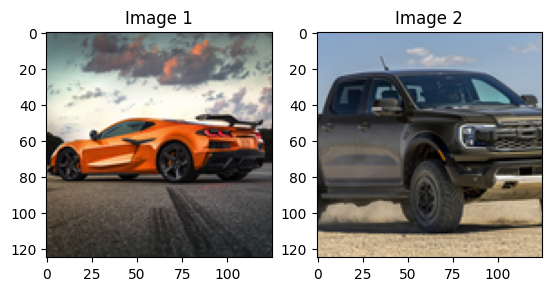

In [6]:
img1 = Image.open('car1.jpg')
img2 = Image.open('car2.jpg')
img1 = central_crop(resize(img1))
img2 = central_crop(resize(img2))
plt.subplot(121)
plt.imshow(np.asarray(img1))
plt.title("Image 1")
plt.subplot(122)
plt.imshow(np.asarray(img2))
plt.title("Image 2")
plt.show()

In [7]:
car1 = Image.open('car1.jpg')
car2 = Image.open('car2.jpg')
out1 = Image.open('out1.jpg')
out2 = Image.open('out2.jpg')
cty1 = Image.open('cty1.jpeg')
cty2 = Image.open('cty2.jpeg')
pop1 = Image.open('pop1.jpeg')
pop2 = Image.open('pop2.jpeg')

car1 = normalize(central_crop(resize(car1)))
car2 = normalize(central_crop(resize(car2)))
out1 = normalize(central_crop(resize(out1)))
out2 = normalize(central_crop(resize(out2)))
cty1 = normalize(central_crop(resize(cty1)))
cty2 = normalize(central_crop(resize(cty2)))
pop1 = normalize(central_crop(resize(pop1)))
pop2 = normalize(central_crop(resize(pop2)))

batch_input = np.concatenate((
    np.asarray(car1)[np.newaxis, ...],
    np.asarray(car2)[np.newaxis, ...],
    np.asarray(out1)[np.newaxis, ...],
    np.asarray(out2)[np.newaxis, ...],
    np.asarray(cty1)[np.newaxis, ...],
    np.asarray(cty2)[np.newaxis, ...],
    np.asarray(pop1)[np.newaxis, ...],
    np.asarray(pop2)[np.newaxis, ...],
    ))

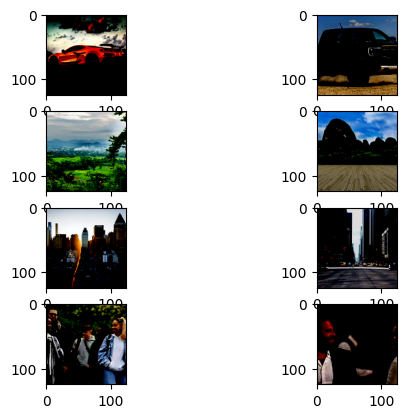

In [8]:
plt.subplot(421)
plt.imshow(car1)
plt.subplot(422)
plt.imshow(car2)
plt.subplot(423)
plt.imshow(out1)
plt.subplot(424)
plt.imshow(out2)
plt.subplot(425)
plt.imshow(cty1)
plt.subplot(426)
plt.imshow(cty2)
plt.subplot(427)
plt.imshow(pop1)
plt.subplot(428)
plt.imshow(pop2)

plt.show()

##Experiments

#### Scoring functions

In [9]:
def get_cosine_score(a,b):
  normalize_a = tf.nn.l2_normalize(a,0)
  normalize_b = tf.nn.l2_normalize(b,0)
  cos_similarity=tf.reduce_sum(tf.multiply(normalize_a,normalize_b))
  return cos_similarity.numpy()

def get_l2_distance(a,b):
  return tf.norm(a-b, ord='euclidean')

def get_avg_cosine_score(a,b):
  score = 0
  num = 0e-5
  for tensor1 in a:
    for tensor2 in b:
      s = get_cosine_score(tensor1, tensor2)
      if s < 1:
        score += s
        num += 1
  return score/num

def get_avg_l2_score(a,b):
  score = 0
  num = 0
  for tensor1 in a:
    for tensor2 in b:
      s = get_l2_distance(tensor1, tensor2)
      if s > 0:
        score += s
        num += 1
  return score/num

def compute_cosine_result(**kargs):
  classes = list(kargs.keys())
  num_classes = len(classes)
  result = np.zeros((num_classes,num_classes))
  for i in range(len(classes)):
    for j in range(len(classes)):
      c_1 = kargs.get(classes[i])
      c_2 = kargs.get(classes[j])
      result[i][j] = get_avg_cosine_score(c_1, c_2)
  return pd.DataFrame(result, columns=classes, index=classes)

def compute_l2_result(**kargs):
  classes = list(kargs.keys())
  num_classes = len(classes)
  result = np.zeros((num_classes,num_classes))
  for i in range(len(classes)):
    for j in range(len(classes)):
      c_1 = kargs.get(classes[i])
      c_2 = kargs.get(classes[j])
      result[i][j] = get_avg_l2_score(c_1, c_2)
  return pd.DataFrame(result, columns=classes, index=classes)

def plot(embeddings):
  cosine_df = compute_cosine_result(
      car=embeddings[:2],
      outdoor=embeddings[2:4],
      city=embeddings[4:6],
      pop=embeddings[6:8]
      )

  l2_df = compute_l2_result(
      car=embeddings[:2],
      outdoor=embeddings[2:4],
      city=embeddings[4:6],
      pop=embeddings[6:8])

  fig, ax = plt.subplots(1, 2, figsize=(10,7))

  sns.heatmap(cosine_df,
      cmap=sns.diverging_palette(220, 10, as_cmap=True),
      square=True,
      annot=True,
      ax=ax[0],
      cbar=False
      )
  ax[0].set_title('Cosine similarity')

  sns.heatmap(l2_df,
      cmap=sns.diverging_palette(220, 10, as_cmap=True),
      square=True,
      annot=True,
      ax=ax[1],
      cbar=False
      )
  ax[1].set_title('L2 distance')


#### model (ResNet50)

In [10]:
encoder = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(WIDTH, HEIGHT, 3),
)

inputs = tf.keras.layers.Input((WIDTH, HEIGHT, 3))
outputs = encoder(inputs)
outputs = tf.keras.layers.GlobalAveragePooling2D()(outputs)
outputs = tf.keras.layers.Flatten()(outputs)

resmodel = tf.keras.Model(inputs=inputs, outputs=outputs)

resmodel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 125, 125, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
_________________________________________________________________


In [11]:
embeddings = resmodel(batch_input)

##### Distance score on different classes

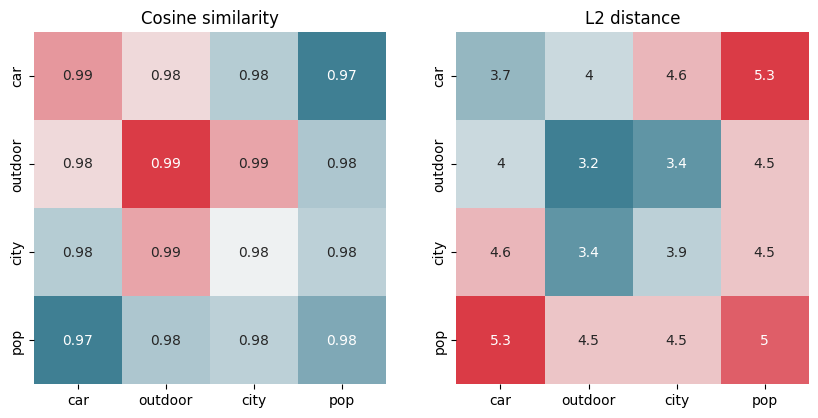

In [12]:
plot(embeddings)

##### Random check

Cosine similarity: 0.983622133731842
L2 distance: 3.816696882247925


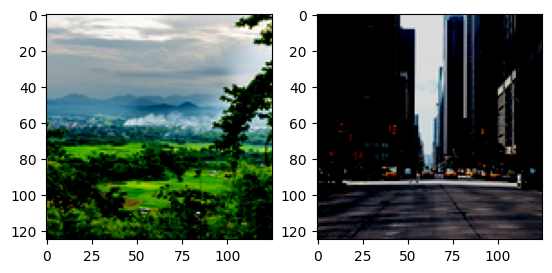

In [13]:
img1 = Image.open('out1.jpg')
img2 = Image.open('cty2.jpeg')
img1 = normalize(central_crop(resize(img1)))
img2 = normalize(central_crop(resize(img2)))
test_batch_input = np.concatenate((
    np.asarray(img1)[np.newaxis, ...],
    np.asarray(img2)[np.newaxis, ...]
))
embeddings = resmodel(test_batch_input)
cosine_score = get_cosine_score(embeddings[0], embeddings[1])
l2 = get_l2_distance(embeddings[0], embeddings[1])

plt.subplot(121)
plt.imshow(img1)
plt.subplot(122)
plt.imshow(img2)

print(f"Cosine similarity: {cosine_score}")
print(f"L2 distance: {l2}")
plt.show()

#### Inception v3

In [14]:
encoder = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(WIDTH, HEIGHT, 3),
)
encoder = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(WIDTH, HEIGHT, 3),
)

inputs = tf.keras.layers.Input((WIDTH, HEIGHT, 3))
outputs = encoder(inputs)
outputs = tf.keras.layers.GlobalAveragePooling2D()(outputs)
outputs = tf.keras.layers.Flatten()(outputs)

incmodel = tf.keras.Model(inputs=inputs, outputs=outputs)

incmodel.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 125, 125, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
Total params: 21,802,784
Trainable params: 21,768,352
Non-trainable params: 34,432
_________________________________________________________________


In [15]:
embeddings = incmodel(batch_input)

##### Distance score on different classes

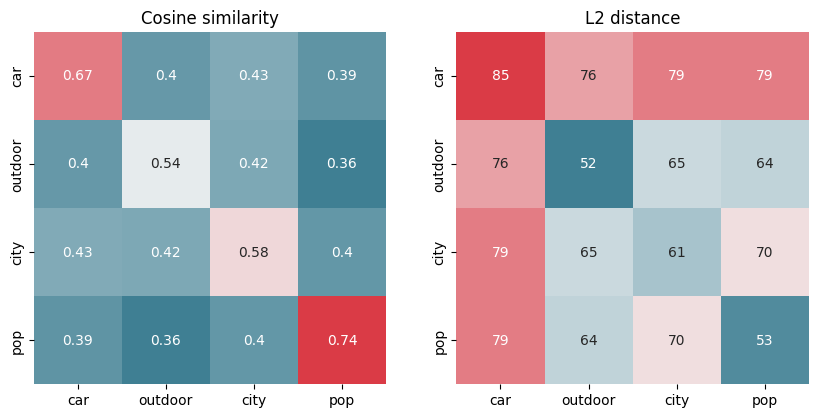

In [16]:
plot(embeddings)

##### reandom check

Cosine similarity: 0.43039512634277344
L2 distance: 63.3040657043457


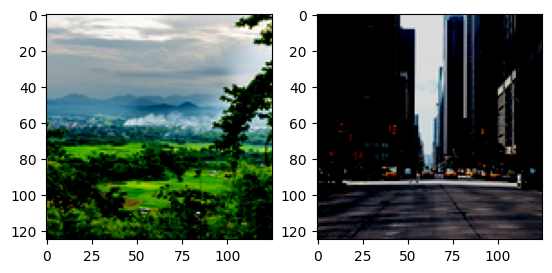

In [18]:
img1 = Image.open('out1.jpg')
img2 = Image.open('cty2.jpeg')
img1 = normalize(central_crop(resize(img1)))
img2 = normalize(central_crop(resize(img2)))
test_batch_input = np.concatenate((
    np.asarray(img1)[np.newaxis, ...],
    np.asarray(img2)[np.newaxis, ...]
))
embeddings = incmodel(test_batch_input)
cosine_score = get_cosine_score(embeddings[0], embeddings[1])
l2 = get_l2_distance(embeddings[0], embeddings[1])

plt.subplot(121)
plt.imshow(img1)
plt.subplot(122)
plt.imshow(img2)

print(f"Cosine similarity: {cosine_score}")
print(f"L2 distance: {l2}")
plt.show()

## Exporting the model in Graph format

In [19]:
!pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.9/189.9 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 86.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 59.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 34.5 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Succ

In [20]:
incmodel.save('model')

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7de12f65ab00>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7de12f65ab00>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('signature_function', 'signature_key'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('signature_function', 'signature_key'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [1]:
# apply float16 quantization
!tensorflowjs_converter \
    --quantize_float16 \
    --input_format=tf_saved_model \
    --output_format=tfjs_graph_model \
    model \
    jsmodel

2023-08-12 15:00:38.416387: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-12 15:00:39.522051: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-08-12 15:01:00.269421: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2023-08-12 15:01:00.269619: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session


In [2]:
!zip -r model.zip jsmodel

  adding: jsmodel/ (stored 0%)
  adding: jsmodel/group1-shard4of11.bin (deflated 7%)
  adding: jsmodel/group1-shard1of11.bin (deflated 8%)
  adding: jsmodel/group1-shard6of11.bin (deflated 8%)
  adding: jsmodel/group1-shard9of11.bin (deflated 8%)
  adding: jsmodel/group1-shard5of11.bin (deflated 8%)
  adding: jsmodel/model.json (deflated 96%)
  adding: jsmodel/group1-shard10of11.bin (deflated 8%)
  adding: jsmodel/group1-shard8of11.bin (deflated 8%)
  adding: jsmodel/group1-shard2of11.bin (deflated 8%)
  adding: jsmodel/group1-shard3of11.bin (deflated 8%)
  adding: jsmodel/group1-shard7of11.bin (deflated 8%)
  adding: jsmodel/group1-shard11of11.bin (deflated 8%)


In [3]:
from google.colab import files
files.download('model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!rm -Rf jsmodel